In [1]:
%pylab inline
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import scanpy as sc
import pandas as pd
import torch
import scipy
import time
from STEM.model import *
from STEM.utils import *

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
scdata = pd.read_csv('./data/MERFISH/human_MTG_2018-06-14_exon-matrix_selected.csv')

In [3]:
stdata = pd.read_csv('./data/MERFISH/donor1_rep3/simu_st_counts.csv',index_col=0)
stdata = stdata.T
stgtcelltype = pd.read_csv('./data/MERFISH/donor1_rep3/simu_st_celltype.csv',index_col=0)
spcoor = pd.read_csv('./data/MERFISH/donor1_rep3/simu_st_metadata.csv',index_col=0)
scmetadata = pd.read_csv('../SMARTseq/human_MTG_2018-06-14_samples-columns.csv',index_col=0)

adata = sc.AnnData(scdata)
adata.obs = scmetadata
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

scdata = pd.DataFrame(adata.X,index=adata.obs_names,columns=adata.var_names)
stadata = sc.AnnData(stdata)
sc.pp.normalize_total(stadata)
sc.pp.log1p(stadata)
stdata = pd.DataFrame(stadata.X,index=stadata.obs_names,columns=stadata.var_names)

stadata.obsm['spatial'] = spcoor

/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [4]:
adata.var_names_make_unique()
stadata.var_names_make_unique()

In [5]:
dprate = 0

In [6]:
class setting( object ):
    pass
seed_all(2022)
opt= setting()
setattr(opt, 'device', 'cuda:0')
setattr(opt, 'outf', 'log/MERFISHdonor1_rep3+smartseq')
setattr(opt, 'n_genes', scdata.shape[1])
setattr(opt, 'no_bn', False)
setattr(opt, 'lr', 0.002)
setattr(opt, 'sigma', 85)
setattr(opt, 'alpha', 0.8)
setattr(opt, 'verbose', True)
setattr(opt, 'mmdbatch', 1000)
setattr(opt, 'dp', dprate)

In [7]:
%%time
testmodel = SOmodel(opt)
testmodel.togpu()
loss_curve = testmodel.train_wholedata(800,torch.tensor(scdata.values).float(),torch.tensor(stdata.values).float(),torch.tensor(spcoor.values).float())

[Train][0] Loss: E 3.283 E_pred 2.969 E_circle 6.085 E_mmd 0.393
[0.002]
[Train][1] Loss: E 7.827 E_pred 6.335 E_circle 6.512 E_mmd 1.866
[0.002]
[Train][2] Loss: E 9.513 E_pred 7.801 E_circle 7.821 E_mmd 2.140
[0.002]
[Train][3] Loss: E 7.110 E_pred 6.292 E_circle 6.054 E_mmd 1.022
[0.002]
[Train][4] Loss: E 8.501 E_pred 7.892 E_circle 8.199 E_mmd 0.761
[0.002]
[Train][5] Loss: E 6.825 E_pred 6.381 E_circle 6.220 E_mmd 0.555
[0.002]
[Train][6] Loss: E 7.173 E_pred 6.795 E_circle 6.808 E_mmd 0.473
[0.002]
[Train][7] Loss: E 7.231 E_pred 6.879 E_circle 6.912 E_mmd 0.440
[0.002]
[Train][8] Loss: E 6.907 E_pred 6.613 E_circle 6.578 E_mmd 0.368
[0.002]
[Train][9] Loss: E 6.571 E_pred 6.276 E_circle 6.065 E_mmd 0.369
[0.002]
[Train][10] Loss: E 6.464 E_pred 6.203 E_circle 5.824 E_mmd 0.325
[0.002]
[Train][11] Loss: E 6.698 E_pred 6.457 E_circle 6.120 E_mmd 0.301
[0.002]
[Train][12] Loss: E 6.459 E_pred 6.216 E_circle 5.851 E_mmd 0.304
[0.002]
[Train][13] Loss: E 6.316 E_pred 6.084 E_circle 

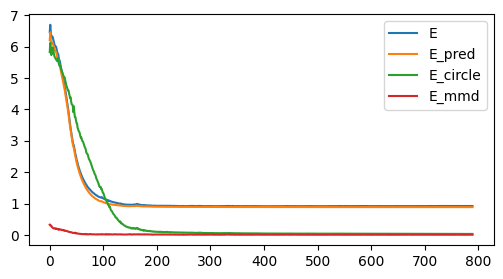

In [8]:
figsize(6,3)
skip=10
N = len(loss_curve['E'])-skip
plt.plot(np.arange(N),loss_curve['E'][skip:],label='E')
plt.plot(np.arange(N),loss_curve['E_pred'][skip:],label='E_pred')
plt.plot(np.arange(N),loss_curve['E_circle'][skip:],label='E_circle')
plt.plot(np.arange(N),loss_curve['E_mmd'][skip:],label='E_mmd')
plt.legend()

In [9]:
testmodel.modeleval()
scembedding = testmodel.netE(torch.tensor(scdata.values,dtype=torch.float32).cuda())

stembedding = testmodel.netE(torch.tensor(stdata.values,dtype=torch.float32).cuda())
netst2sc = F.softmax(stembedding.mm(scembedding.t()),dim=1).detach().cpu().numpy()
netsc2st = F.softmax(scembedding.mm(stembedding.t()),dim=1).detach().cpu().numpy()

In [10]:
np.save('result/230215_testdp_pure_mmd-cortical-donor1_rep3+smartseq.npy',netst2sc)
np.save('result/230215_testdp_pure_sc2st_mmd-cortical-donor1_rep3+smartseq.npy',netsc2st)

np.save('result/230215_scembbedding-cortical-donor1_rep3+smartseq.npy',scembedding.detach().cpu().numpy())
np.save('result/230215_stembbedding-cortical-donor1_rep3+smartseq.npy',stembedding.detach().cpu().numpy())

In [11]:
testmodel.save()